# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [14]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
from CouplesModel import CouplesModel
from HouseholdSpecializationModel import HouseholdSpecializationModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

**Explain how you solve the model**

In [48]:
model = CouplesModel()
model.solve_discrete()

In [49]:
getattr(model.sol_disc,'LM',)

4.5

In [50]:
model.solve_continuous()
model.sol_cont

namespace(LM=4.454493819318181,
          LF=4.454493819318181,
          HM=4.454493592853744,
          HF=4.454493592853744,
          V=-0.2381101577927103)

In [54]:
model.solve_wF_vec()

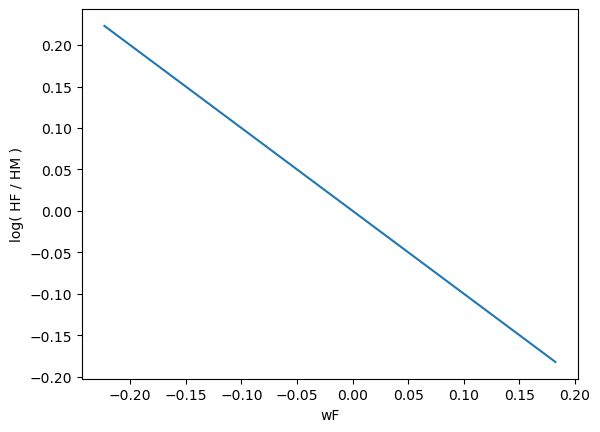

In [61]:
model.plot()

# Question 2

Explain your code and procedure

In [3]:
# code

# Question 3

Explain your code and procedure

In [4]:
# code

ADD CONCISE CONLUSION.